# Validation rSVD Kratos

12 / 02 / 2021

This notebook compares the displacement constructed from the first natural mode and frequency with the displacement reconstructed from the output of KRATOS.

The main steps are:

1. Modal analysis of a cantilever beam with RamSeries.

2. Read the output ascii file to get the first mode and first natural frequency.

3. Create a snapshot matrix with the displacement time history of the first natural mode and natural frequency. 

4. Perform rSVD of the snapshot matrix using KRATOS tools.

5. Reconstruction of the displacement field from Kratos output. 

6. Comparison between the two displacement fields.

## Import libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from KratosMultiphysics.RomApplication.randomized_singular_value_decomposition import RandomizedSingularValueDecomposition

## Function to read the ascii file of a modal analysis with RamSeries

It reads the output file of a modal analysis performed with RamSeries. 
It returns the first nb_first_modes chosen by the user. 

In [15]:
def read_modes_freq_from_file(path_file, nb_first_modes):
    """
    Read natural frequencies and modes from a modal analysis file from Ramseries.
    """
    # Open and read file.
    f = open(path_file, "r")
    lines = f.readlines()
    f.close()

    # Choose the q first modes.
    modes = np.arange(1, nb_first_modes + 1)

    # Create the list of frequencies and choosen modes.
    frequencies = []
    values_list = []
    for i_line, line in enumerate(lines):
        for mode in modes:
            if f'Result "Mode_{mode}_' in line and not "Modes_rotations" in line:
                print(line)
                frequencies.append(float(line.split()[2].split(")")[0]))
                i_jump = 3  # Lines to jump between header and values.
                values = []
                while lines[i_line + i_jump][0].isdigit():
                    values.append(lines[i_line + i_jump])
                    i_jump = i_jump + 1
                values_list.append(values)

    return frequencies, values_list

## Function to compute the snapshot matrix from the modes and natural frequencies of the modal analysis
In this case, I build the snapshot matrix with the first mode. 

In [16]:
def reconstruct_displacement_from_modes(
        frequencies, modes_values_list, t_start=0, nb_periods=10):
    """
    Reconstruct the displacement history with given natural frequencies and modes. The displacement field has a shape
    u(t) = mode * sin (frequency * time)
    """
    # Compute t_end with the chosen number of periods.
    t_end = 10 * 1. / np.min(frequencies)
    duration = t_end - t_start  # in seconds

    # 50 sampling points of the maximum frequency.
    dt_sampling = 0.05 * 1. / np.max(frequencies)

    # Compute number of time steps
    nb_time_steps = round(duration / dt_sampling)

    # Create snapshot matrix
    deg_freedom = 3
    nb_nodes = len(modes_values_list[0])
    snapshot_mtx = np.empty(
        shape=(len(modes_values_list), nb_nodes * deg_freedom, nb_time_steps))

    # Create array of time
    times = np.linspace(t_start, t_end, nb_time_steps)

    # Compute the sinthetic field (sinusoidal for each node)
    for i_mode in np.arange(len(modes_values_list)):
        i_node_snapshot_mtx = 0
        for i_node in np.arange(nb_nodes):
            displ_x = float(modes_values_list[i_mode][i_node].split()[1]) * np.sin(
                frequencies[i_mode] * 2 * np.pi * times)
            displ_y = float(modes_values_list[i_mode][i_node].split()[2]) * np.sin(
                frequencies[i_mode] * 2 * np.pi * times)
            displ_z = float(modes_values_list[i_mode][i_node].split()[3]) * np.sin(
                frequencies[i_mode] * 2 * np.pi * times)

            # Add to snapshot matrix
            snapshot_mtx[i_mode, i_node_snapshot_mtx, :] = displ_x
            snapshot_mtx[i_mode, i_node_snapshot_mtx + 1, :] = displ_y
            snapshot_mtx[i_mode, i_node_snapshot_mtx + 2, :] = displ_z

            # Update index of the snapshot matrix
            i_node_snapshot_mtx = i_node_snapshot_mtx + 3

    return times, np.sum(snapshot_mtx, axis=0)

## Create path to file

In [17]:
path_root = Path("/home/usuari/Documentos/CIMNE/bibliografia/model_order_reduction/notebooks")
name_file = "cantilever_eigenvalue.flavia.res"
path_file = path_root / name_file

## Read the first mode of the file

In [18]:
frequencies, modes_values_list = read_modes_freq_from_file(
        path_file, nb_first_modes=1)

Result "Mode_1_(Freq.: 2.207) (m)" "Modes" 0 Vector OnNodes



## Create the displacement field with the first mode and the first natural frequency

In [19]:
times, SNAPSHOT_MATRIX = reconstruct_displacement_from_modes(
        frequencies, modes_values_list, t_start=0, nb_periods=10)

## Apply Kratos rSVD
The tolerance 1e-6 is relative to the Frobenius norm of the SNAPSHOT_MATRIX.

In [20]:
# Apply Kratos tools
tolerance = 1e-6
u, s, v, _ = RandomizedSingularValueDecomposition().Calculate(
        SNAPSHOT_MATRIX, tolerance)

iter =  1  nC =  1.8288883407032382e-13  dR =  1.0  R =  1


## Reconstruction of the displacement field from Kratos output

In [21]:
# Reconstruction of the displacement field with rSVD
svd = s[0] * u * v.T

## Plot comparison

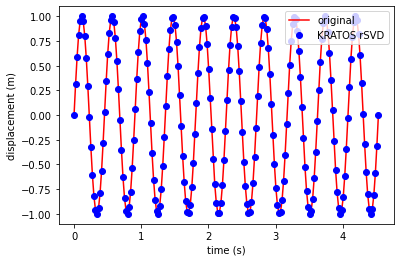

In [22]:
    # Figure parameters
    fig, ax = plt.subplots()
    ax.set_xlabel("time (s)")
    ax.set_ylabel("displacement (m)")

    # Plot the displacement
    plt.plot(times, SNAPSHOT_MATRIX[1, :], color="red", label="original")

    # Plot the reconstructed displacement with the rSVD
    plt.plot(times, svd[1, :], "o", color="blue", label="KRATOS rSVD")

    plt.legend(loc="upper right")
    plt.show()    # Figure parameters